## Decission trees

Decission tress is an algorithm used for both regression and classification which is super easy to interpret since can be encoded as a chain of `IF` `ELSE` statements over the predictor variables. 
Given a collection of labeled examples, $(X,Y)$, where $X = X_1 \times X_2 \times \dotso \times X_m$, the decission tress algorithm can be summarized in two steps:
- Divide the predictor space $X$ into $J$ different non-overlapping regions $R= \{R_{1},R_{2},\dotso, R_{j}\}$
- For a region $R_{i}$, let $(X_{R_{i}},Y_{R_{i}}) \subset (X,Y)$ be all the labeled observations such that $x_{R_{i}}$ falls in $R_{i}$. Then, given a $x\in R_{i}$:
    - If we are doing regression, we will predict the label of $x$ with the mean of $Y_{R_{i}}$
    - If we are doing classification we will predict the label of $x$  with the majority class in $Y_{R_{i}}$ 

For example, if the step one divides the space into two regions $R_{1}$ and $R_{2}$ and the mean of the labels of the samples in  $R_{1}$ is 10 and the mean of the labels of the samples in $R_{2}$ is 30, we will predict 10 is $x\in R_{1}$, otherwise 30.

## Regression

### The minimization problem

As with linear regression, we are going to find a function $f_{R}$ which minimizes the quadratic error $L(R) = \frac{1}{|X|}\sum_{(x,y)\in (X,Y)} (f_{R}(x) - y)^{2}$ of the predictions. The tricky thing here is of course how do we find $R$, the non-overlapping regions of $X$.
For this, we are going to use a *recursive greedy* approach where, at each step, we are going to select one of the variables in $X$ and we are going to split it in two parts based on 

In [1]:
from sklearn.datasets import load_boston,load_iris,load_breast_cancer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import math 

In [2]:
boston_dataset = load_boston()
X = boston_dataset["data"]
y = boston_dataset["target"]

In [141]:
best_cut_for_mse = {}
for i in range(X.shape[1]):
    x_var = X[:,i]
    best_mse = 10**10
    best_cut = None
    for x in x_var:
        mean_y_under_x = np.mean(y[x_var<x])
        mean_y_over_x = np.mean(y[x_var>=x])
        sse = np.sum((y[x_var<x] - mean_y_under_x)**2) + np.sum((y[x_var>=x] - mean_y_over_x)**2)
        mse = (1/len(y))*sse
        if mse<=best_mse:
            best_mse = mse
            best_cut = x
            best_cut_for_mse[i] = [best_mse,best_cut,mean_y_under_x,mean_y_over_x]
            
    

In [62]:
class TreeNode():
    def __init__(self,X,y,max_depth,depth = 0,mean_y = None):
        self.X = X
        self.y = y
        self.leaf = False
        self.depth = depth
        self.max_depth = max_depth
        self.mean_y = mean_y
        
    def fit(self):
        if not (self.X.shape[0]>0 and self.X.shape[1]>0 and self.depth<self.max_depth):
            self.leaf = True
            return 
            
        best_cut = self.get_best_predictor_with_cut()
        self.predictor_idx = best_cut[0]
        self.cut = best_cut[1]
        self.mean_y_under_cut = best_cut[2]
        self.mean_y_over_cut = best_cut[3]
        predictor = self.X[:,self.predictor_idx]
        
        X_left = self.X[predictor<self.cut,:]
        y_left = self.y[predictor<self.cut]
        #X_left = np.delete(X_left,self.predictor_idx,axis = 1)  
        self.left_node = TreeNode(X_left,y_left,self.max_depth,self.depth + 1,self.mean_y_under_cut)
        self.left_node.fit()
    
        X_right = self.X[predictor>=self.cut,:]
        y_right = self.y[predictor>=self.cut]
        #X_right = np.delete(X_right,self.predictor_idx,axis = 1)  
        self.right_node = TreeNode(X_right,y_right,self.max_depth,self.depth + 1,self.mean_y_over_cut)
        self.right_node.fit()
            
    def predict(self,X):
        y_s = []
        for x in X:
            y_s.append(self.predict_(x))
        return np.asarray(y_s)
        
    def predict_(self,x):
        if self.leaf:
            return self.mean_y
        else:
            value_at_predictor = x[self.predictor_idx]
            #x_without_predictor = np.delete(x,self.predictor_idx,axis = 0)
            x_without_predictor = x
            if value_at_predictor < self.cut:
                return self.left_node.predict_(x_without_predictor)
            else:
                return self.right_node.predict_(x_without_predictor)
        
    def get_best_predictor_with_cut(self):

        best_mse = 10**10
        for predictor_idx in range(self.X.shape[1]):
            best_mse_of_predictor = 10**10
            predictor = self.X[:,predictor_idx]
            for cut in predictor:
                mean_y_under_cut = np.mean(self.y[predictor<cut])
                mean_y_over_cut = np.mean(self.y[predictor>=cut])
                sse = np.sum((self.y[predictor<cut] - mean_y_under_cut)**2) + np.sum((self.y[predictor>=cut] - mean_y_over_cut)**2)
                mse = (1/len(self.y))*sse
                if mse<=best_mse_of_predictor:
                    best_mse_of_predictor = mse
                    best_cut_of_predictor = [predictor_idx,cut,mean_y_under_cut,mean_y_over_cut]
                    
            if best_mse_of_predictor<best_mse:
                best_mse = best_mse_of_predictor 
                best_cut = best_cut_of_predictor
                    
        return best_cut
    
    def get_error(self):
        if self.leaf:
            return np.sum((self.mean_y - self.y)**2)
        else:
            return self.left_node.get_error() + self.right_node.get_error()
                

model = TreeNode(X,y,4)
model.fit()
y_pred = model.predict(X)

In [63]:
model.get_error()

4880.779104426192

In [64]:
np.dot(y - tree.predict(X),y - tree.predict(X))

4880.779104426193

In [56]:
tree = DecisionTreeRegressor(random_state = 0,max_depth = 4)
tree.fit(X,y)

DecisionTreeRegressor(max_depth=4, random_state=0)

In [57]:
np.dot(y - tree.predict(X),y - tree.predict(X))

4880.779104426193

## Classification

In [132]:
breast_cancer_dataset = load_breast_cancer()
X = breast_cancer_dataset["data"]
y = breast_cancer_dataset["target"]

In [133]:
X.shape

(569, 30)

In [161]:
from collections import Counter
import math

def compute_entropy(props):
    entropy = 0
    for prop in props:
        entropy-=props[prop]*math.log(props[prop])
    return entropy


class TreeNode():
    def __init__(self,X,y,max_depth,depth = 0,mean_y = None):
        self.X = X
        self.y = y
        self.leaf = False
        self.depth = depth
        self.max_depth = max_depth
        self.mean_y = mean_y
        
    def fit(self):
        if not (self.X.shape[0]>0 and self.X.shape[1]>0 and self.depth<self.max_depth):
            self.leaf = True
            return 
            
        best_cut = self.get_best_predictor_with_cut()
        self.predictor_idx = best_cut[0]
        self.cut = best_cut[1]
        self.mean_y_under_cut = best_cut[2]
        self.mean_y_over_cut = best_cut[3]
        predictor = self.X[:,self.predictor_idx]
        
        X_left = self.X[predictor<self.cut,:]
        y_left = self.y[predictor<self.cut]
        #X_left = np.delete(X_left,self.predictor_idx,axis = 1)  
        self.left_node = TreeNode(X_left,y_left,self.max_depth,self.depth + 1,self.mean_y_under_cut)
        self.left_node.fit()
    
        X_right = self.X[predictor>=self.cut,:]
        y_right = self.y[predictor>=self.cut]
        #X_right = np.delete(X_right,self.predictor_idx,axis = 1)  
        self.right_node = TreeNode(X_right,y_right,self.max_depth,self.depth + 1,self.mean_y_over_cut)
        self.right_node.fit()
            
    def predict(self,X):
        y_s = []
        for x in X:
            y_s.append(self.predict_(x))
        return np.asarray(y_s)
        
    def predict_(self,x):
        if self.leaf:
            return self.mean_y
        else:
            value_at_predictor = x[self.predictor_idx]
            #x_without_predictor = np.delete(x,self.predictor_idx,axis = 0)
            x_without_predictor = x
            if value_at_predictor < self.cut:
                return self.left_node.predict_(x_without_predictor)
            else:
                return self.right_node.predict_(x_without_predictor)
        
    def get_best_predictor_with_cut(self):

        best_entropy = 10**10
        for predictor_idx in range(self.X.shape[1]):
            best_entropy_of_predictor = 10**10
            predictor = self.X[:,predictor_idx]
            for cut in predictor:
                prop_y_under_cut = Counter(self.y[predictor<cut])
                prop_y_over_cut = Counter(self.y[predictor>=cut])
                prop_y_under_cut = {x:prop_y_under_cut[x]/len(self.y[predictor<cut]) for x in prop_y_under_cut}
                prop_y_over_cut = {x:prop_y_over_cut[x]/len(self.y[predictor>=cut]) for x in prop_y_over_cut}
                entropy = 0
                if len(self.y[predictor<cut])>0:
                    entropy += compute_entropy(prop_y_under_cut)*(len(self.y[predictor<cut])/len(self.y) ) 
                if len(self.y[predictor>=cut])>0:
                    entropy += compute_entropy(prop_y_over_cut)*(len(self.y[predictor>=cut])/len(self.y) ) 
                
                if entropy<=best_entropy_of_predictor:
                    best_entropy_of_predictor = entropy
                    best_cut_of_predictor = [predictor_idx,cut,prop_y_under_cut,prop_y_over_cut]
                    
            if best_entropy_of_predictor<best_entropy:
                best_entropy = best_entropy_of_predictor 
                best_cut = best_cut_of_predictor
                    
        return best_cut
    
    def get_error(self):
        if self.leaf:
            return np.sum((self.mean_y - self.y)**2)
        else:
            return self.left_node.get_error() + self.right_node.get_error()
                

model = TreeNode(X,y,4)
model.fit()
y_pred = model.predict(X)

In [162]:
y_pred

array([{0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 0.8, 1: 0.2}, {0: 1.0},
       {0: 0.8, 1: 0.2}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0},
       {0: 1.0}, {0: 1.0},
       {0: 0.5714285714285714, 1: 0.42857142857142855}, {0: 1.0},
       {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {1: 1.0}, {1: 1.0},
       {1: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0},
       {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0},
       {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {1: 1.0}, {0: 1.0},
       {0: 1.0}, {0: 0.047619047619047616, 1: 0.9523809523809523},
       {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {0: 1.0}, {1: 1.0},
       {0: 1.0}, {1: 1.0},
       {0: 0.047619047619047616, 1: 0.9523809523809523}, {1: 1.0},
       {1: 1.0}, {1: 1.0}, {0: 1.0}, {0: 1.0}, {1: 1.0}, {0: 1.0},
       {0: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {1: 1.0}, {0: 1.0},
       {1: 1.0}, {0: 1.0}, {0: 1.0},
       {0: 0.047619047619047616, 1: 0.9523809523809523}, {1: 1.0},
       {0: 0.8, 1: 0.2}, {1: 1.0}

In [163]:
tree = DecisionTreeClassifier(random_state = 0,max_depth = 4,criterion = "entropy") 
tree.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [165]:
tree.predict_proba(X,)[:20]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ]])

In [175]:
n = 10000
((n-1)**n)/(n**n) 

0.36786104643292994

In [1]:
from sklearn.datasets import load_boston,load_iris,load_breast_cancer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import math 
from decission_trees import HomemadeDecisionTreeRegressor

In [3]:
boston_dataset = load_boston()
X = boston_dataset["data"]
y = boston_dataset["target"]

In [6]:
homemade_tree_regressor = HomemadeDecisionTreeRegressor(X,y,4)
homemade_tree_regressor.fit()
homemade_y = homemade_tree_regressor.predict(X)

In [7]:
print(np.mean((homemade_y-y)**2))

9.64580850677113


In [8]:
tree = DecisionTreeRegressor(random_state = 0,max_depth = 4)
tree.fit(X,y)
y_ = tree.predict(X)

In [9]:
print(np.mean((y_-y)**2))

9.64580850677113


### Boosting

In [24]:
X.shape

(506, 13)

In [25]:
X_train = X[:400,:]
y_train = y[:400]

X_test = X[400:,:]
y_test = y[400:]

In [59]:
model = HomemadeDecisionTreeRegressor(X_train,y_train,1)
model.fit()

In [61]:
np.mean((model.predict(X_test) - y_test)**2)

71.9672683504299

In [60]:
np.mean((model.predict(X_train) - y_train)**2)

42.78250537698119

In [68]:
residual = y_train
alpha = 0.1
its = 200
current_prediction = np.zeros(len(y_train))
weak_models = []

def evaluate_model(weak_models,X,y):
    final_prediction = np.zeros(len(y))
    for weak_model in weak_models:
        final_prediction+=alpha*weak_model.predict(X)
    return(np.mean((y-final_prediction)**2))
    
errors = []
for i in range(its):
    weak_model = HomemadeDecisionTreeRegressor(X_train,residual,2)
    weak_model.fit()
    weak_models.append(weak_model)
    pred = weak_model.predict(X_train)
    current_prediction = current_prediction + alpha*pred
    residual = (residual - alpha*pred)
    test_error = evaluate_model(weak_models,X_test,y_test)
    train_error = evaluate_model(weak_models,X_train,y_train)
    errors.append({"test_error":test_error,"train_error":train_error,"it":i})

/home/guillermo/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
/home/guillermo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars


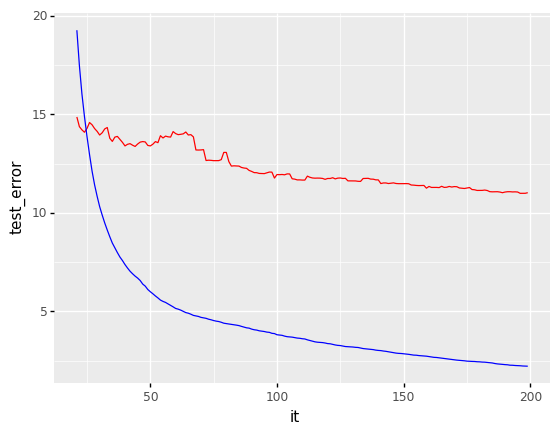

<ggplot: (8777411177494)>

In [69]:
import pandas as pd
from plotnine import *
errors = pd.DataFrame(errors)
ggplot(errors[errors["it"]>20]) + geom_line(aes(x = "it",y = "test_error"),color = "red") + geom_line(aes(x = "it",y = "train_error"),color = "blue")



In [44]:
errors

[{'test_error': 210.4730868306747, 'train_error': 555.6683450216265, 'it': 0},
 {'test_error': 159.83880868408778, 'train_error': 458.064557587304, 'it': 1},
 {'test_error': 120.96313933720235, 'train_error': 378.7411297568498, 'it': 2},
 {'test_error': 96.45035501961213, 'train_error': 314.08835467614773, 'it': 3},
 {'test_error': 74.01284145510043, 'train_error': 261.3012202859834, 'it': 4},
 {'test_error': 58.386576411082714, 'train_error': 218.1490751548711, 'it': 5},
 {'test_error': 48.410409823537485,
  'train_error': 182.98912667034486,
  'it': 6},
 {'test_error': 39.420453778823614, 'train_error': 154.2520411067183, 'it': 7},
 {'test_error': 33.292853680106276, 'train_error': 130.7300962617664, 'it': 8},
 {'test_error': 29.360328516004017,
  'train_error': 111.51428750068114,
  'it': 9},
 {'test_error': 27.058854566065545,
  'train_error': 95.67940479589254,
  'it': 10},
 {'test_error': 25.55485862070962, 'train_error': 82.66713641734748, 'it': 11},
 {'test_error': 23.187924578

In [23]:
np.mean((y-final_prediction)**2)

14.51105945449502